## Insights into trends with global greenhouse gases and climate change action.

EPA1333 – Computer Engineering for Scientific Computing Final Project

### Authors
Group 6:
* Aashna Mittal
* Gamze Ünlü (4744640)
* Jason R Wang (4788281)

## Executive Summary

In this analysis, we analyzed the implications of United Nations Framework Convention on Climate Change (UNFCCC) on member states' Nationally Determined Contributions (NDCs). 

In Section 1, we combine and clean differnet data sets to get the data in useful form for the later analysis. Later we provide an overview of the world and the current situation comparing the NDCs submitted and temperature targets. 

In Section 2, we start focusing on the countries and the question "Which countries are polluting more?". We narrow down the analysis to top 10 most polluting countries and visualize their 2030 projected emissions in no policy case and their submitted NDCs. We compute their target reduction of emissions. 

In Section 3, we broaden our analysis with the notion of "Historical Debt" which is one of the important discussion points within Paris Agreement. We see the historical emissions of the top 10 emittors. Later we find the relation between their %reduction target, GDPs and cumualative emissions. With this analysis countries are grouped into four different categories in order to compare their contributions to global warming and their targets. 

In Section 4, we introduce the Green Climate Fund pledges and visualize how much each country pledged to contribute. We later compare this amount with the number they should contribute which is found within the analysis in this section. Following up from Section 3, "Guilt Factor" is used to come up with recommendations on how much top 10 emitters should contribute to the Green Climate Fund and how much their NDCs targets should be. 

Section 5 discusses the reccomendations and conclusions of the analysis. -- present birefly what is found.... 

## Introduction

Anthropogenic climate change was first introduced into the global political arena as the United Nations Framework on Climate Change Convention (UNFCCC) in 1992. Since then, other international agreements have continued to refine mitigation action. The [United Nations Sustainable Development Goal 13](https://sustainabledevelopment.un.org/sdg13), 'Take urgent action to combat climate change and its impacts*', specifically targets this global issue.

At 19th Conference of the Parties (to the UNFCCC) in 2013 in Warsaw, the UNFCCC members agreed to submit "Intended Nationally Determined Contributions" (INDCs) to signal what each country's greenhouse gas emission targets would be. At the 21st Conference in 2015, the Paris Agreement formalized these _intended_ emissions into simply "Nationally Determined Contributions" (NDCs).

Furthermore, the signatories to the Paris Agreement (which includes all UNFCCC signatories, and therefore, all UN member nations) have agreed to maintain global warming to 2ºC, but preferrably 1.5ºC, above pre-industrial levels. This Notebook intends to analyze the NDCs to estimate their potential to reach these temperature goals.

For some nations, these NDCs require a net reduction. For industrializing nations, they are simply lower than a calculated 'business-as-usual' (BAU) scenario – they are still allowed to grow their total emission footprint.

![](https://i.imgur.com/mHjPRPo.png)

## Methodology

Our methodology during the analysis follows the below steps: 

- Gathering data sources 
- Data cleaning
- Selecting the data to use for analysis
- Visual inferences 
- Calculating guilt index for the recommendations 

In [142]:
# Import libraries used throughout analysis

from numpy import array
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import NaN
plt.style.use('ggplot')

## 1. NDCs and Temperature Targets

To determine the impact of NDCs, we need to first understand their context by answering the following questions:
1. What do global emissions look like today? (and what datasets can we rely on?)
2. If nothing changes, and the world continues doing _business as usual_ (BAU), how will the world look like in 2030?

Then, we can examine how NDCs compare:
3. If all NDCs are met, what will the total amount of emissions be?
4. What emission amounts are required to meet temperature targets?

Finally, all of this will be compared in 1.5.

_Note: Emissions are quantified in units of 'megatons of carbon dioxide-equivalent per year' [MtCO2e/yr] because the strength all greenhouse gases are measured relative to carbon dioxide and because the carbon cycle is a process. Global climate targets assume that natural GHG uptake will continue steadily, so reducing the rate of emissions from countries will lead to a net decrease in the concentration of GHGs in the atmosphere._

### 1.0 Import and Clean Greenhouse Gas Emission Data

Many organizations maintain databases of current (and historical) GHG emissions. The primary data source for most of them is from the UNFCCC's reporting window; each UNFCCC member submits annual 'GHG Inventories', which track national emissions with two-year delay.

The World Bank, the World Resources Institute, and the Potsdam Institute for Climate all have published datasets based on varying methodology. Below is an explanation of our approach to finding a valid set to perform further analysis on.

First examine WB data since it is most conveniently accessible and matches other easily-comparable datasets. The WB set records GHG information in _ktCO2e_, includes natural emissions, and has data from 1970-2012 and uses global warming potentials from the IPCC AR2 report.
    
Source: https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE?view=chart

In [143]:
# Import World Bank data on GHGs
ghgDf_WB = pd.read_csv("data/GreenhouseGasData.csv", sep=',', skipinitialspace=True, skiprows=4, index_col=1) 

# Drop the indicator name and indicator code as the values are same across the whole dataframe
ghgDf_WB = ghgDf_WB.drop(["Indicator Code", "Indicator Name"], axis = 1)

# Drop all the columns that contain only null values
ghgDf_WB.dropna(axis = 1, how="all", inplace=True)  

# Drop all the rows that contain only null values, starting from column 2
ghgDf_WB.dropna(axis = 0, how="all", subset = ghgDf_WB.columns[2:], inplace= True)  

# Interpolate missing values and then use backfill to fill starting NA values of a row
ghgDf_WB.iloc[:,2:] = ghgDf_WB.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

# Convert all emissions data into MtCO2e
ghgDf_WB.iloc[:,1:] = ghgDf_WB.iloc[:,1:].divide(1000)

In [144]:
# View the cleaned WB GHG DataFrame
# ghgDf_WB.head()

There are some aggregate regions in our data, like ARB-Arab World. Luckily, the World Bank data has a list we can use to remove these aggregate regions.

In [145]:
# Import the dataframe which contains the codes of country group aggregates except 'WLD-World', the last row.We want to keep 
#the world for now.

CountryGroupCodes = pd.read_excel("data/CountryGroups.xls", sheet_name = "List of economies", skiprows=226, header = None)
CountryGroupCodes.dropna(how="all", inplace=True, axis=1)
CountryGroupCodes.drop(columns=0,inplace=True)
CountryGroupCodes.dropna(how="all", inplace=True, axis=0)
CountryGroupCodes.columns = ["Aggregate Name", "Aggregate Code"]
CountryGroupCodes = CountryGroupCodes.iloc[:-1]
CountryGroupCodes.head()

,Aggregate Name,Aggregate Code
0,Arab World,ARB
1,Caribbean small states,CSS
2,Central Europe and the Baltics,CEB
3,Early-demographic dividend,EAR
4,East Asia & Pacific,EAS


In [146]:
# Drop the rows corresponding to aggregate country codes from existing dataframe to create a new country dataframe 
ghgDf_WB = ghgDf_WB.drop(CountryGroupCodes["Aggregate Code"].values)

We create a dictionary for simplicity with key as country codes and values as the country names. Since the World Bank's naming scheme matches the [ISO-3166-1 standard](https://en.wikipedia.org/wiki/ISO_3166-1) for country names and country codes, it will be used as the reference list.

In [147]:
countryDictionary = dict( ghgDf_WB.reset_index().set_index('Country Code').iloc[:,0] )
list(countryDictionary.items())[:5]

[('ABW', 'Aruba'),
 ('AFG', 'Afghanistan'),
 ('AGO', 'Angola'),
 ('ALB', 'Albania'),
 ('ARE', 'United Arab Emirates')]

The World Bank's data spans from 1970 to 2012. The CAIT greenhouse gas data spans 1990 to 2014. It would be interesting to see a large a temporal range as much as possible. Note that the UNFCCC started recording emissions data from 1990.

The CAIT Excel workbook also contains another sheet with total CO2 emissions from 1850 to 2014. This may also be interesting for analysis.

In [148]:
# For both sets, use the ISO code as the index because it follows the ISO-3166 standard, unlike the country names!
# GHGs from 2013 and 2014
ghgDf_CAITghg = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017_ISO.xlsx",
                               sep=',', sheet_name='GHG Emissions', skipinitialspace=True, skiprows=1, index_col=1)

# CO2 emissions from 1850
ghgDf_CAITco2 = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017_ISO.xlsx",
                               sep=',', sheet_name='CO2 Total Emissions', skipinitialspace=True, index_col=1).dropna()

In [149]:
#ghgDf_CAITghg.head()

But since we already have a large set of World Bank greenhouse gas data, we shall first attempt to append the CAIT greenhouse gas data onto it. To do so, we must filter, clean, and structure the 2013 and 2014 years into the same format that the World Bank uses.

In [150]:
ghgDf_CAITghg1314 = ghgDf_CAITghg[ (ghgDf_CAITghg['Year'] == 2013) | (ghgDf_CAITghg['Year'] == 2014) ]\
    .loc[:,['Year','Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)']]

# Pivot the table to be in the same format as the World Bank data, which is in a nicer format
# (since we are only looking at total emissions).
ghgDf_CAITghg1314 = ghgDf_CAITghg1314.pivot(columns='Year',
                  values='Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)')

#ghgDf_CAITghg1314.head()

Before we merge the datasets, it is important to see how the two sets of data might align. Do the countries match? Are the greenhouse gases quantified in the same way?

In [151]:
# These countries are in CAIT data but not the World Bank's:
ghgDf_CAITghg.loc[ ghgDf_CAITghg1314.index[~ghgDf_CAITghg1314.index.isin(ghgDf_WB.index)], 'Country' ].unique()

array(['Andorra', 'Cook Islands', 'European Union (28)', 'Liechtenstein',
       'Montenegro', 'Niue', 'Nauru', 'Palau', 'Serbia', 'World'],
      dtype=object)

In [152]:
# These countries are in World Bank data but not CAIT's:
[countryDictionary[i] for i in ghgDf_WB.index[~ghgDf_WB.index.isin(ghgDf_CAITghg1314.index)] ]

['Aruba',
 'American Samoa',
 'Bermuda',
 'Cayman Islands',
 'Gibraltar',
 'Guam',
 'Hong Kong SAR, China',
 'Macao SAR, China',
 'Northern Mariana Islands',
 'New Caledonia',
 'Puerto Rico',
 'French Polynesia',
 'Turks and Caicos Islands',
 'Timor-Leste',
 'British Virgin Islands',
 'Virgin Islands (U.S.)',
 'World']

Clearly, there are some discrepancies. There is some CAIT data for smaller states that do not appear in the World Bank's data. The World Bank includes many regions that CAIT does not care for. 'World' shows up in both but uses a different Code ('World' is not in ISO-3166 since it is not a country).

But, for the rest of the ISO-3166 countries, we can join the datasets.

In [153]:
# Join by matching index. Recall that we pivoted ghgDf_CAITghg1314 to be in the same format as the World Bank data.
ghgDf_merged = ghgDf_WB.join(ghgDf_CAITghg1314)

# And let's fill in missing data using `interpolate`.
ghgDf_merged.iloc[:,2:] = ghgDf_merged.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

# Convert all emissions data into MtCO2e
ghgDf_merged.iloc[:,1:] = ghgDf_merged.iloc[:,1:].divide(1000)

# ghgDf_merged.head()

Lastly, let's add in the Potsdam Institute for Climate's (PIK) PRIMAP data, which also interpolates in years where data is missing for countries like we did.

>Gütschow, Johannes; Jeffery, Louise; Gieseke, Robert; Gebel, Ronja (2018): The PRIMAP-hist national historical emissions time series (1850-2015). V. 1.2. GFZ Data Services. http://doi.org/10.5880/PIK.2018.003

In [154]:
ghgDf_PIK = pd.read_csv('data/primap-hist_v1/PRIMAP-hist_v1.2_14-Dec-2017.csv')
ghgDf_PIK = ghgDf_PIK.rename(columns = {'country': 'Country Code'}).drop(columns=['scenario'])

This data set only has country codes and not country names. Fortunately, since it uses standardized names, the World Bank maintains a matching sheet.

In [155]:
# Drop the columns of countries that are not in the WB database
ghgDf_PIK = ghgDf_PIK[ ghgDf_PIK['Country Code'].isin(countryDictionary.keys()) ]

In [156]:
# The PIK data doesn't come with names, so let's add them.
ghgDf_PIK['Country Name'] = [ countryDictionary[i] for i in ghgDf_PIK['Country Code'] ]

In [157]:
# From the user guide file included with this database, we only want:
# scenario = 'HISTORY' and category = 'CAT0' (all emissions including LULUCF).
# Luckily, the country codes are in ISO format and the format is otherwise similar
# to the World Bank's dataset. 'Country Name' is also used as an index to match WB.

ghgDf_PIK = ghgDf_PIK.set_index(ghgDf_PIK['Country Code'])\
                .query("category == 'CAT0'").query("entity == 'KYOTOGHG'")\
                .drop(columns=['Country Code','category','entity','unit'])


In [158]:
# Convert from GgCO2e (same as KtCO2e) to MtCO2e
ghgDf_PIK.iloc[:,:-1] = ghgDf_PIK.iloc[:,:-1].divide(1000)

In [159]:
# ghgDf_PIK.head()

### 1.1 Data Selection

Now, let's see how all the data compare. Let's take the simple case of world emissions from the World Bank, the CAIT databases, and from PIK.

In [160]:
from ipywidgets import interact

@interact( lowerYear=(1850,2014), upperYear=(1851,2015) )
def h( lowerYear=1970, upperYear=2015 ):
    CAIT_world = ghgDf_CAITghg\
        .loc['WORLD',['Year','Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)']]
    plt.plot(CAIT_world['Year'].values,CAIT_world.iloc[:,1])

    WB_world = ghgDf_WB.loc[['WLD']].melt(id_vars='Country Name',var_name='Year')
    plt.plot(WB_world.iloc[:,1].astype(int).values,WB_world.iloc[:,2])

    CAIT_world_co2 = ghgDf_CAITco2.loc['WORLD']
    plt.plot(CAIT_world_co2['Year'].values,CAIT_world_co2.iloc[:,-1])

    PIK_world = ghgDf_PIK.loc[:,:'2015'].sum()
    plt.plot( PIK_world.index.astype(int) ,PIK_world.values)
    
    plt.xlim([lowerYear,upperYear])
    plt.xlabel('Year')
    plt.ylabel('Emissions [GtCO2e]')
    plt.title('Emissions [GtCO2e/yr] from All GHG Data Sources')
    plt.legend(['CAIT - All GHGs','World Bank - All GHGs','CAIT – CO2','PIK - All GHGs'])
    plt.figure(figsize=(10, 10), dpi=80)
    plt.show()


interactive(children=(IntSlider(value=1970, description='lowerYear', max=2014, min=1850), IntSlider(value=2015…

Unfortunately, there are discrepancies in the data that overlaps between these countries in all of these datasets! Note the huge change between 2012 and 2013 data between the World Bank and CAIT data. Therefore, merging them really isn't a good idea.

Upon further investigation, these discrepancies are rooted in the different methodologies. Looking deeper in both datasets' sources, they both use CO2 emissions from the International Energy Agency (IEA) but other sources separately too.

* World Bank: Uses IEA and their own independent research ([World Bank Methodology](http://edgar.jrc.ec.europa.eu/methodology.php))
* CAIT: Uses the "IEA source for CO₂ emissions from fossil fuel combustion from 1971 to 2011, and draws the remaining CO₂ and non-CO₂ emissions data from a variety of other sources including CDIAC, U.S. EPA, and FAO." ([CAIT Methodology](http://cait2.wri.org/faq.html))
* PIK: Consolidates many published datasets similar to the above (see section 3.1 of Nabel et al.). ([PIK Methodology](http://dataservices.gfz-potsdam.de/pik/showshort.php?id=escidoc:2959897) | [Nabel et al. (2011)](https://doi.org/10.1016/j.envsoft.2011.08.004))

Typical discrepancies relate to:
* Accounting for biomass emissions (some forms of biomass is treated as 'biogenic' and counted as zero)
* Natural fires and other land-based occurences, which are incredibly difficult to count.

**Final Choice of Data: **

**Therefore, going forward, we are going to use only the PIK GHG data from 1850 to 2014. It is the most comprehensive, within the range of the others (through visual inspection), and is equally valid as the others in that it is used by authorities and decision-makers around the world.**

### 1.2 BAU Forecasts

The Climate Watch dataset, which is related to the CAIT data, at https://climatewatchdata.org (maintained by the World Resource Institute and supported by other organizations) includes the Global Change Assessment Model (GCAM), which includes a 'no policy' scenario for global emissions. This scnenario is useful to make comparison with 2030 NDC targets of the countries. 

In [161]:
# Use index_col=2, the region, as the index. Drop the Model column, since it is the same across the whole Df.
ghgForecast_GCAM = pd.read_excel("data/wri/Pathways/GCAM.xlsx",
                                 sheet_name = "GCAM_Timeseries data",index_col=2)\
                    .drop(['Model'],axis=1)

In [162]:
# For sake of consistency, we should match these names up with the ISO codes.
# Since this data is from CAIT, hopefully we can match names and ISO codes with `ghgDf_CAITghg`
ghgForecast_GCAM[ghgForecast_GCAM.index.isin(ghgDf_CAITghg['Country'])].index.unique()

Index(['Argentina', 'Brazil', 'Canada', 'China', 'Colombia', 'India',
       'Indonesia', 'Japan', 'Mexico', 'Pakistan', 'South Africa', 'World'],
      dtype='object', name='Region')

In [163]:
# And for completeness, check in with the World Bank country names:
GCAMinWB = ghgForecast_GCAM[ghgForecast_GCAM.index.isin(countryDictionary.values())].index.unique()
GCAMinWB

Index(['Argentina', 'Brazil', 'Canada', 'China', 'Colombia', 'India',
       'Indonesia', 'Japan', 'Mexico', 'Pakistan', 'South Africa',
       'United States', 'World'],
      dtype='object', name='Region')

In [164]:
# Invert our earlier dictionary of country names and codes
countryDictionaryInv = {v: k for k, v in countryDictionary.items()}

In [165]:
# The United States is in the World Bank list.
ghgForecast_GCAM.loc[ GCAMinWB, 'Country Code'] = \
[ countryDictionaryInv[i] for i in ghgForecast_GCAM.loc[ GCAMinWB ].index ]

# Drop everything else
ghgForecast_GCAM.dropna(axis='rows',subset=['Country Code'],inplace=True)
ghgForecast_GCAM = ghgForecast_GCAM.set_index('Country Code')

In [166]:
#ghgForecast_GCAM.head()

Filter the dataset for just the information we're looking for: the 'No policy' scenario and for total GHG emissions. Note that all the emissions are in [MtCO2e/yr] format already.

In [167]:
ghgForecast_GCAM_BAU_all = \
    ghgForecast_GCAM[ (ghgForecast_GCAM['Scenario'] == 'No policy') &
                    (ghgForecast_GCAM['ESP Indicator Name'].str.startswith('Emissions|GHG')) ] \
                    .drop(columns=['Scenario','ESP Indicator Name','Unit of Entry'])

#ghgForecast_GCAM_BAU_all.head()

In [168]:
# This dataset gives projections by each type of greenhouse gas but in CO2e. These need to be merged for each country.

ghgForecast_GCAM_BAU_all = ghgForecast_GCAM_BAU_all.reset_index()

ghgForecast_GCAM_BAU = {}

for i in ghgForecast_GCAM_BAU_all['Country Code'].unique():
    ghgForecast_GCAM_BAU[i] = ghgForecast_GCAM_BAU_all[ghgForecast_GCAM_BAU_all['Country Code']==i].sum()['2005':]

ghgForecast_GCAM_BAU = pd.DataFrame(ghgForecast_GCAM_BAU).T

In [169]:
#ghgForecast_GCAM_BAU.head()

In [170]:
#2030 emissions, if countries take no measures: 

print('The total projected GHG emissions for the no policy scenario in 2030 is: {:.2f} MtCO2e/yr.'.format(
    ghgForecast_GCAM_BAU.loc['WLD','2030'] ) )

The total projected GHG emissions for the no policy scenario in 2030 is: 62542.00 MtCO2e/yr.


### 1.3 NDCs in 2030

The same ClimateWatch source contains NDCs in the format:

    ISO Country Code, Country Name, Goal Year, Value (in MtCO2e/yr), if goal is a range, and the type of goal.

In [171]:
NDCsDf_raw = pd.read_csv('data/wri/CW_NDC_quantification_April30.csv')
NDCsDf = NDCsDf_raw.dropna(axis=0).drop(328) #328 is a mis-entry, as determined through inspection

# Check data input
#NDCsDf.head(5)

Some countries' NDCs are given as a range. For simplicity, this analysis will only examine the mean of that range.

In [172]:
rangedIndices = NDCsDf[NDCsDf['Range'] == 'Yes'].index

# Note that each range is a pair
for i in range(0,len(rangedIndices)-1,2):    
    NDCsDf.loc[rangedIndices[i],'Value'] = (
        (NDCsDf['Value'][rangedIndices[i]] + NDCsDf['Value'][rangedIndices[i+1]])/2
    )
    
# Drop the column 'Range', since it is not really needed anymore,
# and drop the EU-28 (since they have been disaggregated by country).
NDCsDf = NDCsDf.drop(labels=rangedIndices[1::2], axis=0).drop(labels='Range', axis=1)
NDCsDf = NDCsDf.drop(index=NDCsDf.loc[NDCsDf['ISO'] == 'EU28'].index.values, axis=0)

From here on, the situation in 2030 will be the primary focus. Where countries have not submitted data for 2030, the furthest value is used. Furthermore, the best case where the higher goal between choices (e.g. uncondintional is chosen if both unc. and cond. exist) is taken.

Note that the EU, which is collectively a large emitter, has only submitted NDCs for 2020.

In [173]:
NDC_byCountry = []

for i in NDCsDf['ISO'].unique():
    NDC_byCountry.append(NDCsDf[NDCsDf['ISO']==i]['Value'].min() )

In [174]:
NDCs_clean = pd.DataFrame({'Country': NDCsDf['ISO'].unique(),'Goal':    NDC_byCountry})
NDCs_clean = NDCs_clean.set_index('Country')

In [175]:
#2030 emissions if all countries satisfy their NDCs. 

print('If this best case, where all NDCs are met, then the 2030 emissions will be {:.2f} MtCO2e/yr.' \
     .format( NDCs_clean.values.sum() ))

If this best case, where all NDCs are met, then the 2030 emissions will be 42330.46 MtCO2e/yr.


### 1.4 Comparison of NDCs with Required Temperature Targets

Before we can directly compare NDCs to global emissions and targets, we have to filter some data. Not every country has submitted NDCs – as of 2018-10-23, only 177 of 195 UNFCCC members. For those have not yet submitted NDCs, they will be given the benefit of the doubt; the global pathways projections should also filter out the countries that have not yet submitted NDCs by using a 'conversion factor' to neglect these countries.

The Intergovernmental Panel on Climate Change (IPCC) recently released a report about emissions pathways required to reach 1.5ºC of warming. They noted that "all but one" model require emissions reduce to *at most 35 GtCO2e/yr by 2030*. Most pathways require *at most 50 GtCO2e/yr* in 2030 for 2.0ºC of warming.

>IPCC. (2018). IPCC special report on the impacts of global warming of 1.5 °C - Summary for policy makers. Retrieved from http://www.ipcc.ch/report/sr15/

In [ ]:
countriesWithNDCs = NDCsDf['ISO'].unique()

# To make sure the consistency between PIK and CAIT data sources we come up with a conversion factor:
# Divide the 'World' values used in the GCAM projection by filtered actual GHG emissions in 2005 and 2010
convFactor = ghgForecast_GCAM_BAU.loc['WLD',['2005','2010']] \
            / ghgDf_PIK.reindex(countriesWithNDCs).loc[:,['2005','2010']].sum().values

# Take the average conversion factor between 2005 and 2010
convFactor = convFactor.mean()
convFactor

1.1274161667432092

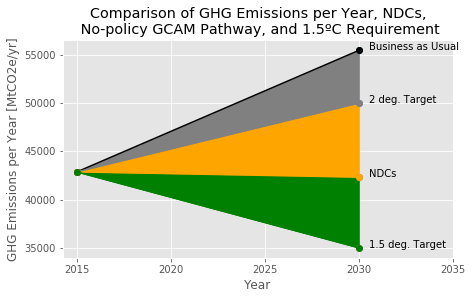

In [178]:
#Visualize the analysis up until now. 

# Set the size of the figure 
plt.figure(figsize=(7,4)) 

# Plot all the data points for the years 2015 and 2030
plt.plot(2015,ghgDf_PIK['2015'].sum()/convFactor,'o',
         2030, ghgForecast_GCAM_BAU.loc['WLD','2030']/convFactor,'o',
         2030,50000,'o',
         2030,NDCs_clean.values.sum(),'o',
         2030,35000,'o')

# Annotate the plotted points to visualize meaningful labels for the scenarios
plt.annotate("Business as Usual", xy = (2030, ghgForecast_GCAM_BAU.loc['WLD','2030']/convFactor), xycoords = 'data',\
             xytext=(10,0), textcoords='offset points')
plt.annotate("2 deg. Target", xy = (2030, 50000), xycoords = 'data', xytext=(10,0), textcoords='offset points')
plt.annotate("NDCs", xy = (2030, NDCs_clean.values.sum()), xycoords = 'data', xytext=(10,0), textcoords='offset points')
plt.annotate("1.5 deg. Target", xy = (2030, 35000), xycoords = 'data', xytext=(10,0), textcoords='offset points')
 
# Initialize the x and y values to be used for plotting scenario lines
x1 = [2015,2030]
y1 = [ghgDf_PIK['2015'].sum()/convFactor, ghgForecast_GCAM_BAU.loc['WLD','2030']/convFactor]
y2 = [ghgDf_PIK['2015'].sum()/convFactor, 50000]
y3 = [ghgDf_PIK['2015'].sum()/convFactor, NDCs_clean.values.sum()]
y4 = [ghgDf_PIK['2015'].sum()/convFactor, 35000]

# Calculate coefficients for the fitting 1 degree polynomial
CoeffLineNoPolicy = np.polyfit(x1,y1,1)
CoeffLineLowTarget = np.polyfit(x1,y2,1)
CoeffLineNDCs = np.polyfit(x1,y3,1)
CoeffLineHighTarget = np.polyfit(x1,y4,1)

# Pass the coefficents of the polynomial to get the linear equation 
LineNoPolicy = np.poly1d(CoeffLineNoPolicy)
LineLowTarget = np.poly1d(CoeffLineLowTarget)
LineNDCs = np.poly1d(CoeffLineNDCs)
LineHighTarget = np.poly1d(CoeffLineHighTarget)

# Plot the lines 
plt.plot(x1, LineNoPolicy(x1), "-o", color = "black")
plt.plot(x1, LineLowTarget(x1), "-o", color = "grey")
plt.plot(x1, LineNDCs(x1), "-o", color = "orange")
plt.plot(x1, LineHighTarget(x1), "-o", color = "green")

# Fill color between lines
plt.fill_between(x1, LineNoPolicy(x1), LineLowTarget(x1), color = "grey")
plt.fill_between(x1, LineLowTarget(x1), LineNDCs(x1), color = "orange")
plt.fill_between(x1, LineNDCs(x1), LineHighTarget(x1), color = "green")

# Set attributes of the plot
plt.xticks(range(2015, 2036, 5))
plt.xlabel('Year')
plt.ylabel('GHG Emissions per Year [MtCO2e/yr]')
plt.title('Comparison of GHG Emissions per Year, NDCs,\n No-policy GCAM Pathway, and 1.5ºC Requirement')

# Show the plot
plt.show()

This graph shows different pathways starting from year 2015. If the world continiues without taking any measures for the climate change (Bussines as Usual scenario) emissions continiue to increase and end up in a way more higher position than the 2 degrees target. If all of the countries keep their promises and satisfy their NDCs, we observe that emissions are even below the 2 degrees target. However this can be considered as an optimistic scenario since there are already some countries like US who plant to withdraw from the agreement. Also for the NDC data used here some assumptions are made as explained in the above sections. Even if the all countries satisfy their NDCs, 1.5 degree target is still not met. This means most of the countries still need to do more than they already promised. In the next section we analyze which countries need to do more. 

## 2. Which countries are polluting more?

### 2.1 Top 10 greenhouse gas emitters

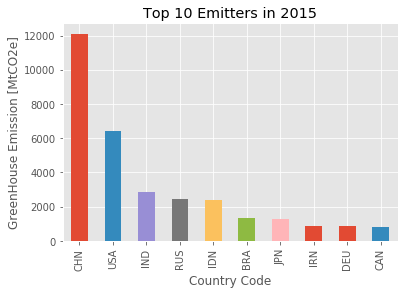

In [179]:
# Sorted bar chart for 2015 greenhouse gas emissions. 

ghgDf_PIK.drop 

GHGTop10 = ghgDf_PIK.sort_values(by = "2015", ascending = False).iloc[:10,:]
GHGTop10["2015"].plot(x=ghgDf_PIK.index, kind="bar")

plt.ylabel("GreenHouse Emission [MtCO2e]")
plt.title('Top 10 Emitters in 2015')
plt.show()

In this simple graph for 2015, we see the top 10 most polluting countries in the world. We observe that China, USA and India are the most polluting countries followed by Russia, Indonesia, Brazil, Japan, Iran, Germany and Canada. We can see China has a huge difference with the rest of the world. 

### 2.2 Top 10 Polluters by pledged NDCs

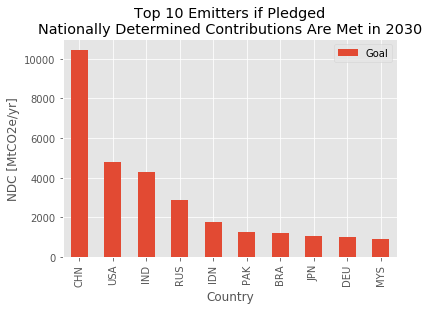

In [180]:
# See who the top 10 polluters are in 2030 when all the NDCs are met.

NDCs_clean.sort_values(by="Goal", ascending=False)[:10].plot(kind="bar")
plt.ylabel("NDC [MtCO2e/yr]")
plt.title("Top 10 Emitters if Pledged\nNationally Determined Contributions Are Met in 2030")
plt.show()

Note that: IND-India and IDN-Indonesia.

This graph shows the greenhouse gas emissions in 2030 in case countries meet their currently pledged NDCs. We observe that in this case, the major polluters don't change and the top 3 stays same: China, USA and India. We observe that Pakistan and Malasia are added to the list. Even though they are not among top 10 polluters in the first graph, with their pledged NDC targets they are among the top 10 emitters in 2030. This might be due to better reduction performance of the other countries or less reduction amount of Pakistan and Malaysia compared to others. 

### 2.3 2030 Projected Emissions vs. Emissions with NDCs Achieved

It would be interesting to see how projected emissions match with NDCs and to then see who is reducing the most.

Unfortunately, the projections from GCAM do not include every country – even ones that are in the top current 10 emitters or in the top 10 emitters under the NDC-achieved scenario!

However, we can try to approximate the GCAM projections for each country by making a few assumptions.
1. The 'World' boundary in both the GCAM projection and in the PIK data are the same.
2. A scaled down 'World' (let us call it World*) value will only eliminate countries who have not submitted their NDCs.
3. There are no countries that have a projection but have not submitted their NDCs (we will verify this below).
4. We can subtract the current and projected emissions of countries who have projections from the remaining World* and the 2015 PIK data to have only countries who have submitted NDCs and do not have a projection.
5. The proportional contribution of these countries in 2015 will be the same in 2030 (i.e. we will _not_ account for differences in growth rate).

In [181]:
# Check assumption 3 listed above
GCAMnotInNDC = ghgForecast_GCAM.index.unique()\
            [~ghgForecast_GCAM.index.unique().isin(NDCsDf['ISO'].unique())]
[countryDictionary[i] for i in GCAMnotInNDC]

['World']

World' is a region and not a country. Thus, we can be assured that we can apply 4. appropriately from the scaled-down World*.

In [182]:
# We actually want to know the opposite list of countries – those with projections and NDCs.
GCAMinNDC = ghgForecast_GCAM.index.unique()\
            [ghgForecast_GCAM.index.unique().isin(NDCsDf['ISO'].unique())]

# 4. Find countries with NDCs, drop those with projections (or no GHG data)
#    and their proportional contributions to 2015 global emissions
ghg_NDCnoGCAM = ghgDf_PIK.reindex(NDCsDf['ISO'].unique())\
                    .drop(GCAMinNDC).dropna().loc[:,['2015','Country Name']]
ghg_NDCnoGCAM['2015 Proportion'] = ghg_NDCnoGCAM['2015']/ghg_NDCnoGCAM['2015'].sum()

In [183]:
# 5. Distribute these proportions to 2030 projections (minus countries with projections)
ghg_NDCnoGCAM['2030'] = ghg_NDCnoGCAM['2015 Proportion'] * \
                    ( ghgForecast_GCAM_BAU.loc['WLD','2030'] / convFactor \
                        - ghgForecast_GCAM_BAU.reindex(GCAMinNDC)['2030'].sum() )

In [184]:
# Combine GCAM forecasts and our own extrapolated forecasts into a DataFrame
ghgForecast_BAU = pd.concat(
    [ghgForecast_GCAM_BAU,ghg_NDCnoGCAM.reindex(columns=['2030'])], sort=True)

In [185]:
ghgForecast_BAU.head()

,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
ARG,294.678,708.487,427.928,519.111,602.419,661.391,711.014,779.129,862.189,940.489,1063.23
BRA,1565.78,1957.24,1458.74,1860.84,2231.86,2319.03,2379.19,2565.83,2877.71,3124.74,3407.9
CAN,631.481,955.523,618.312,753.145,782.063,818.413,855.111,880.473,896.781,998.638,1073.52
CHN,9061.54,10756.2,13027.8,15607.4,17643.3,18984.4,19991.6,20734.1,20822.9,20607.8,19600.2
COL,91.9607,118.837,237.045,309.074,425.59,476.541,506.414,592.094,704.413,829.162,961.265


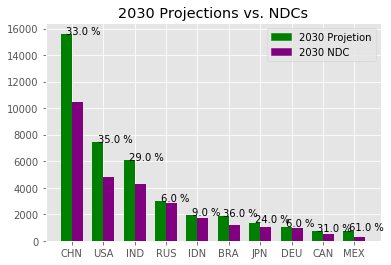

In [186]:
# Now we can plot the 2030 projections vs. the NDCs of the top 10 polluting countries. 

ghgTop20 = ghgDf_PIK.sort_values(by = "2015", ascending = False).iloc[:20,:].index

# NDCs of the top 10 current countries, sorted by the top 2015 emitters.
NDCsTop10 = NDCs_clean.reindex(ghgTop20).dropna()[['Goal']][:10].astype(float)

# Filter the forecasts to the same top 10 current emitters.
topForecast = ghgForecast_BAU.reindex(ghgTop20).dropna(subset=['2030'])[['2030']][:10].astype(float)

# Values to use in the graph. Missing countries are dropped from NDC list. 
y1 = topForecast["2030"].values
y2 = NDCsTop10["Goal"].values
x = np.arange(len(y1))

# Plot bar-chart. 
bar_width = 0.35 
plt.bar(x,y1,width=bar_width,color="green")
plt.bar(x+bar_width,y2,width=bar_width,color="purple")

plt.xticks(x+bar_width/2,NDCsTop10.index)
plt.title("2030 Projections vs. NDCs")

# Patches are used to plot the NDCs and 2030 projections side by side. 

green_patch=mpatches.Patch(color="green",label="2030 Projetion")
purple_patch=mpatches.Patch(color="purple",label="2030 NDC")
plt.legend(handles=[green_patch,purple_patch])

#The % amount that countries need to reduce to achieve their targets:    
NDCTop10 = NDCsTop10.join(topForecast)

NDCTop10["% reduction"] = NDCTop10[["Goal","2030"]]\
            .apply(lambda x: round(((x["2030"] - x["Goal"]) * 100) / x["2030"]), axis = 1)

NDCreductionlabels = NDCTop10["% reduction"].astype(str).values + " %"

for i in range(len(y1)):
    plt.text(x=x[i],y=y1[i],\
         s = NDCreductionlabels[i])

plt.show()

This graph shows for 2030 the differences between Bussines-as-Usual case and the NDCs for the countries, including as an absolute percent change (they are all negative). We observe that USA has to do more compared to China, the top current annual polluter. Mexico has the largest relative change at 61% followed by Brazil at 36%. Below, we will compare the percentage reductions with the historical debts (cumulative emissions since 1850) of the countries to see the relation between their targets and historical emissions – and weigh how ambitious their targets are.

In [ ]:
## This is a new plot and needs to be moved down!

y3 = [10000,8000,1,2,3,4,5,6,7,8] # Obligations

# Plot bar-chart. 
bar_width = 0.2
plt.bar(x,y1,width=bar_width,color="green")
plt.bar(x+bar_width,y2,width=bar_width,color="purple")
plt.bar(x+bar_width*2,y3,width=bar_width,color="orange")

plt.xticks(x+bar_width/3,NDCsTop10.index)
plt.title("2030 Projections vs. NDCs")

# Patches are used to plot the NDCs and 2030 projections side by side. 

green_patch=mpatches.Patch(color="green",label="2030 Projetion")
purple_patch=mpatches.Patch(color="purple",label="2030 NDC")
orange_patch=mpatches.Patch(color="orange",label="Obligation")
plt.legend(handles=[green_patch,purple_patch,orange_patch])

for i in range(len(y1)):
    plt.text(x=x[i],y=y1[i],\
         s = NDCreductionlabels[i])

plt.show()

### 3. Historical responsibility for climate change

#### *Is it fair to put the same burden of greenhouse reduction on developing countries considering the historical emissions produced by developed countries?*

Developing countries and international advocacy organization have argued that owing to their historical emissions, the developed countries owe a "climate debt" to poor countries (Pickering & Barry, 2012). The developed countries have enjoyed the fruit of industrial development way before the developing countries, and have used more than their fair share of Earth's ability to absorb greenhouse gases. Now, the call for reducing global emissions to combat climate change constrains the development of developing countries. Therefore, the developed countries should repay the climate debt by rapdily reducing their emissions and providing financial support to developing countries to upgrade their technologies (Pickering & Barry, 2012). 

The UNFCCC acknowledges this point of contention through the principle of Common but Differentiated Responsibilities and Respective Capabilities (CBDR–RC) stating that the countries should *"protect the climate system for the benefit of present and future generations of humankind, on the basis of equity and in accordance with their common but differentiated responsibilities and respective capabilities"* thereby urging the developed countries to take the lead on climate action (UNFCCC, 1992). The Paris Agreement also reaffirmed this obligation of developed countries.

However, the developed countries have argued to revise the crude 1992 definition of developing countries that sees 6 out of the 10 richest nations of the world as 'developing'. They have stressed that countries who are in a position to contribute financially should do so. 

This section analyses the cumulative historical emissions of the top polluters of the world and throws light on the their NDC reductions in relation to the cummulative emissions and GDP per capita. Further, the countries' contribution to the Green Climate Fund is analyzed to understand if the historical polluters are doing their bit to support climate mitigation in the developing countries.

References:
UNFCCC. (1992). United Nations Framework Convention on Climate Change. Retrieved from http://unfccc.int/files/essential_background/convention/background/application/pdf/convention_text_with_annexes_english_for_posting.pdf

Pickering, J., & Barry, C. (2012). On the concept of climate debt: Its moral and political value. Critical Review of International Social and Political Philosophy, 15(5), 667–685. https://doi.org/10.1080/13698230.2012.727311

The Telegraph. 2018. What is the Paris Agreement on climate change? Everything you need to know. https://www.telegraph.co.uk/business/0/paris-agreement-climate-change-everything-need-know/

### 3.1 Time series for greenhouse gases of major polluters (from 1990 to 2014)

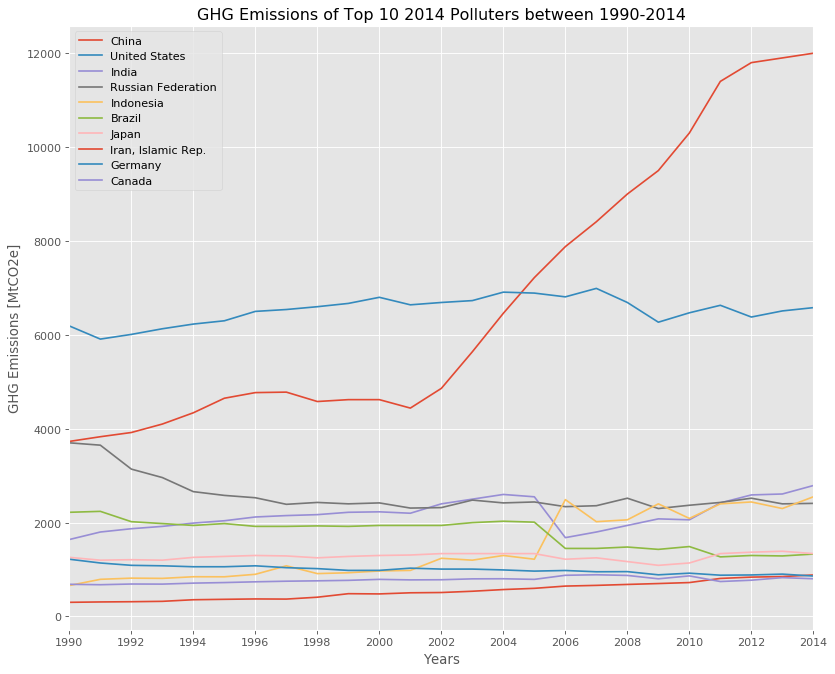

In [187]:
# First lets observe the time series for ghg emissions of the top 10 most polluting countries. 

plt.figure(figsize=(12, 10), dpi=80) 

for i in range(0,10):
    
    row = GHGTop10.iloc[i,140:-2]
    plt.plot(row.index.astype(int),row)

plt.MaxNLocator(5)
plt.xlabel("Years")
plt.ylabel("GHG Emissions [MtCO2e]")
plt.title("GHG Emissions of Top 10 2014 Polluters between 1990-2014")
plt.xticks(range(1990,2015,2))
plt.xlim([1990,2014])
plt.legend(loc=((1.05,0.3)))
plt.legend( [countryDictionary[i] for i in GHGTop10.index] )
plt.show()

In this graph we observe the time series emissions for GHG emissions since the year 1990 to 2014. We observe that even though the United States has been a historical polluter, it's emissions have stabilized over time. Until the beginning of 2000s, US is the major polluter. On the other hand, after this point, China's emissions have sky-rocketed making it the top polluter as of 2015. This intensifies the debate on whether historical emissions or present emissions should be taken into account for deciding the responsibility of countries towards combating climate change. Therefore, we now analyze the carbon debt of the countries. 

### 3.2 Carbon Debt

Which countries are the major emitters of greenhouse gases considering the emissions starting from the year 1850?

In [188]:
# Add a new column to the ghg dataset called cummulative emissions which is equal to the sum of ghg emissions from 1850 to 2015
ghgDf_PIK["Cummulative Emissions"] = ghgDf_PIK.loc[:,"1850":"2015"].sum(axis = 1)
#ghgDf_PIK.head()

In [189]:
ghgCumulative = ghgDf_PIK[["Cummulative Emissions"]]
ghgCumulative.head()

,Cummulative Emissions
Country Code,
ABW,404.4787
AFG,1365.6530
AGO,12229.5500
ALB,642.6100
ARE,5344.8962


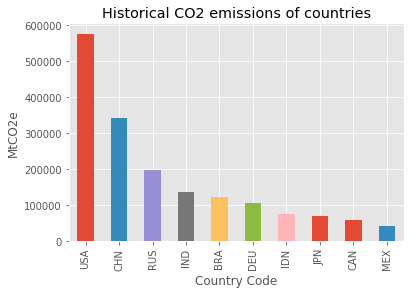

In [190]:
# Join the cumulative emissions to the dataset containing NDCs data of the top 10 emitters according to sorted NDC list. 
CountriesHistDebt = NDCTop10.join(ghgCumulative)

# Plot the cumulative emissions of the top 10 present emitters in the form of a bar chart
CountriesHistDebt["Cummulative Emissions"].sort_values(ascending=False).plot(kind="bar",\
                                                                             title = "Historical CO2 emissions of countries")
plt.ylabel("MtCO2e")
plt.show()

The above plot shows that even thoguh China is the top polluter, USA has been the major historical emitter of greenhouse gases followed by China, and Russia. This puts the onus on the United States to provide the leadership for supporting climate change in developing countries. This graph can be compared with graph of the present emissions. 

### 3.3 Relation between historical debt, % reduction in greenhouse gases promised and GDP per capita

In this part, we bring in another aspect/indicator that throws light on the relative economic positions of these countries. i.e. their GDP per capita.

How does the historical debt relate to countries' present GDP per capita (2017 values) and the % reduction in greenhouse gases promised for the year 2030?

In [191]:
# Import the World Bank csv containing the gdp per capita values for all countries
GDPperCapitaWB = pd.read_csv("data/world bank/GDP_per_capita.csv", skiprows=4, index_col = "Country Code", header = 0,\
                             skipinitialspace = True)

# Drop entries where row values are all null
GDPperCapitaWB.dropna(how="all", axis=0, inplace=True)

# Drop entries where column values are all null
GDPperCapitaWB.dropna(how="all", axis=1, inplace=True)
GDPperCapitaWB.drop(columns = ["Indicator Name","Indicator Code"], inplace = True)
GDPperCapitaWB.iloc[:,1:] = GDPperCapitaWB.iloc[:,1:].interpolate(axis = 1)

# Extract only the latest data i.e. the 2017 column
GDPperCapita2017 = GDPperCapitaWB[["2017"]]
GDPperCapita2017.head()

,2017
Country Code,
ABW,25324.720362
AFG,585.850064
AGO,4170.312280
ALB,4537.862492
AND,39146.548836


In [192]:
#Merge the GDP dataset to the Historical Emissions dataset by their index 
HistoricalDebtMergedDf = CountriesHistDebt.join(GDPperCapita2017)
HistoricalDebtMergedDf.rename(columns = {"2017":"GDP per cap", "2030":"2030 NDC emissions"}, inplace=True)
HistoricalDebtMergedDf.head()

,Goal,2030,% reduction,Cummulative Emissions,2017
Country Code,,,,,
CHN,10456.53,15607.407558,33.0,341004.0,8826.994096
USA,4805.10,7438.822216,35.0,576609.0,59531.661964
IND,4298.31,6073.252796,29.0,135363.0,1939.612984
RUS,2849.25,3020.476772,6.0,198066.0,10743.096592
IDN,1740.50,1908.847029,9.0,74339.0,3846.864323


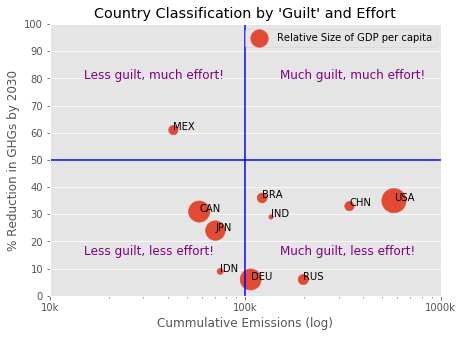

In [193]:
# Set the figure size for plot
plt.figure(figsize = (7,5))

# Create a scatter plot of cummulative emissions vs. % reduction in NDCs with the size of the plot equivalent to the country's
# GDP per capita.
p = plt.scatter(x=HistoricalDebtMergedDf["Cummulative Emissions"]/1000,\
                y=HistoricalDebtMergedDf["% reduction"],\
            s = HistoricalDebtMergedDf["2017"]/100, color = '#069af3')

# Set the attributes for the plot
# Since the data is skewed towards large values, we convert the x axis into a logarithmic scale
plt.xscale("log")
plt.xlabel("Cummulative Emissions [GtCO2e] (log)")
plt.ylabel("% Lower than GCAM/Our\nNo-Policy Scenario Forecast in 2030")
plt.grid(True)
plt.xticks([10,100,1000], ["10","100", "1000"])
plt.yticks([i*10 for i in range(11)])
plt.title("Country Classification by 'Guilt' and Effort")

# Place the country codes as a text next to the scatter points 
for i in range(len(list(HistoricalDebtMergedDf.index))):
    plt.text(x=HistoricalDebtMergedDf.iloc[i,3]/1000,y=HistoricalDebtMergedDf.iloc[i,2],\
    s = list(HistoricalDebtMergedDf.index)[i])

## Format the plot to categorize the nations and show a relative difference in their level of ambition.

# Divide the grid horizontally
plt.axhline(y=50, color='#b9a281')
# Divide the grid vertically
plt.axvline(x=100, color='#b9a281')

# Assign a text to each quadrant in the plot
plt.text(x=150, y=80, s="Much guilt, much effort!", color = 'Orange', size = 12)
plt.text(x=15, y=80, s="Less guilt, much effort!", color = 'Green', size = 12)
plt.text(x=15, y=15, s="Less guilt, less effort!", color = '#601ef9', size = 12)
plt.text(x=150, y=15, s="Much guilt, less effort!", color = 'Red', size = 12)
plt.legend([p],['Relative Size of\n Current Emissions'])

# Show the plot
plt.show()

The above plot shows that even though both China and USA have high historical emissions, USA's GDP per capita is way higher than China which further bolsters the argument that USA has both the capacity and the responsibility to take the lead on climate change. We see other countries who are guilty but do not have high GDP as USA. These countries might need financial support. On the other hand, we see countries like Mexico reducing their emissisons by almost 60% by 2030 even though their historical emissions are realtively lower compared to the top 10 present emitters. We see some countries who have less historcial emissions are also putting less effort such as Canada, Japan and Indonesia. There are no contries who put very much effort for being guilty!

### 4. Required Financial Contributions and Emission Reductions

What should be the NDCs and financial contributions of the top 10 countries according to their historical emissions and GDP per capita?

### 4.1 Green Climate Fund Pledges

The Green Climate Fund (GCF) is an international fund set up through the UNFCCC to help developing nations build projects that align with global emissions reduction goals. Projects include those for renewable elecricity or other technologies for reducing emissions. 

The advanced economies have agreed to aggregate USD 100 billion per year by the year 2020 in order to support the mitigation and adaptation initiatives in developing countries.

All pledges made by countries are [listed online](https://www.greenclimate.fund/how-we-work/resource-mobilization) in an interactive table but does not provide the data cleanly.

In [194]:
import requests
from bs4 import BeautifulSoup

page_name = 'https://www.greenclimate.fund/how-we-work/resource-mobilization'
page = requests.get(page_name)

soup = BeautifulSoup(page.text, 'html.parser')

contrib = soup.find(class_='res-table')
contribItems = contrib.find_all('tbody')[0].find_all('tr')

country, announced = [],[]

for i in range(len(contribItems)):
    scrapedInfo = contribItems[i].find_all('td')
    country.append(scrapedInfo[0].contents[0])
    announced.append(float(
        scrapedInfo[1].contents[0].replace('$','').strip('M').replace(',','').replace('<','').strip() )
                    * 1000000)

In [195]:
gcfBS = pd.DataFrame({'Pledges':announced},index=country)

In [196]:
for i in gcfBS.index:
    if i in countryDictionaryInv:
        gcfBS.loc[i,'Country Code'] = [countryDictionaryInv[i]]
    else: # escape from keys that don't exist
        next
gcfBS.index.name = 'Country'

In [197]:
# gcfBS.reset_index().set_index('Country Code')

In [198]:
# From visual inspection, the column 'Year' and index 'World' is not necessary
gcfDf = pd.read_csv('data/green-climate-gcf-fund-pledges.csv',index_col=0).drop(columns='Year').drop('World')

# Rename the columns to be more readable and index name to be 'Country' instead of 'Entity'
gcfDf = gcfDf.rename(columns={'Code':'Country Code',
                      'Signed pledges (GCF) (US$ per year)':'Pledges'})
gcfDf.index.name = 'Country'

# Check the data
gcfDf.head()

,Country Code,Pledges
Country,,
Australia,AUS,187000000.0
Austria,AUT,34800000.0
Belgium,BEL,66900000.0
Bulgaria,BGR,100000.0
Canada,CAN,277000000.0


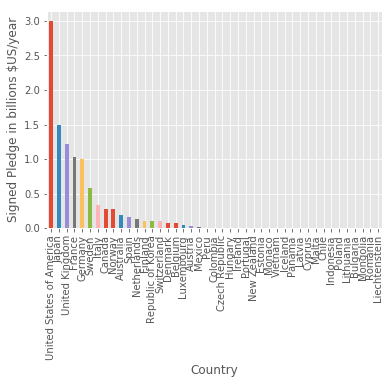

In [199]:
gcfBS['Pledges'].divide(1e9).sort_values(ascending=False).plot.bar(by='Pledges')
plt.ylabel('Signed Pledge in billions $US/year')
plt.show()

In this graph we observe the pledges of countries to the Green Climate Fund. US is the country who pledged to contribute most, followed by Japan and United Kingdom. We observe that the most of the top polluting countries do not pledge high amounts of contribution to the fund. This is because of their low GDP per capita values. Thus how much countries should contribute also depends on their wealth together with their historical emissions. Next we try to find out the required contribution of the countries depending on these two factors.  

### 4. Recommendations: How much countries should contribute to the green climate fund and what should be their NDCs.?

#### 4.1 Calculating the guilt factor

In [ ]:
# Add the 2017 GDP per capita values to the ghg emissions dataset 
ghgDf_PIK = ghgDf_PIK.join(GDPperCapita2017)
ghgDf_PIK.head()

In [ ]:
# Rename the column "2017" to "GDP per cap"
ghgDf_PIK.rename(columns = {"2017":"GDP per cap"}, inplace = True)

# Add a new column to the ghg dataset which contains the product of columns - cummulative emissions and GDP per cap
ghgDf_PIK["GDP Emission Product"] = ghgDf_PIK["Cummulative Emissions"] * ghgDf_PIK["GDP per cap"]
ghgDf_PIK.head()

# Sum the values of the emission product column to get the denominator of the guilt factor formula
# Remember, we aren't looking at the whole world and only looking at countries that have submitted the NDCs, hence the denomitor
# is scaled down by the conversion factor
GuiltFactorDen = ghgDf_PIK["GDP Emission Product"].sum() / convFactor

In [ ]:
# Caulculate the guilt factor for the top 10 current emitters by multiplying their cummulative emissions with GDP per capita and
# dividing by the denominator calculated above.
HistoricalDebtMergedDf["Guilt Factor"] = (HistoricalDebtMergedDf["Cummulative Emissions"] * \
                                          HistoricalDebtMergedDf["GDP per cap"]) / GuiltFactorDen

In [ ]:
# Plot the guilt factor
HistoricalDebtMergedDf["Guilt Factor"].sort_values(ascending = False).plot(kind='bar')

The above plot shows that USA and Germany have the highest guilt factors owing to their high historical emissions and high GDP per capita. Thus, it can be expected from these countries to contribute to the green climate fund in proportion to their guilt factor.

#### 4.2 What should be the contribution towards climate fund?

In [ ]:
# Initialize the yearly Green Climate Fund (GCF) Target
ClimateFundTargetYearly = 10 ** 11

# Scale down the GCF target to what the top 10 emitters should contribute based on their own cummulative emissions
# relative to the world
ScaledDownTarget = round(ClimateFundTargetYearly * (HistoricalDebtMergedDf["Cummulative Emissions"].sum()\
                                              /ghgDf_PIK["Cummulative Emissions"].sum()) / 10 ** 9, 2)

print ("In proportion to their cummulative emissions, the top 10 emitters should collectively pay " + \
       ScaledDownTarget.astype(str) + " billion USD to the Green Climate Fund yearly")

In [ ]:
# Add a new column to the HistoricalDebtMergedDf dataset that calculates the contribution of each top emitter as 
# Scaled Down Target * Guilt Factor
HistoricalDebtMergedDf["GCF contribution"] = HistoricalDebtMergedDf["Guilt Factor"] * ScaledDownTarget

# Plot the contribution of each country as a pie chart
HistoricalDebtMergedDf["GCF contribution"].sort_values(ascending = False).plot\
(kind='pie', title = "Propose country share in Green Climate Fund (bn USD)", figsize = (6,6)).set_aspect('equal')

#### 4.3 What should be the NDCs of the top 10 emitters?

Assuming that the total reduction in greenhouse gases should be done by the top 10 emitters, we finally comment on what NDCs should the top 10 emitters pledge corresponding to their guilt factor that would enable the world to stay within the temperature target of 1.5 degrees by 2030.

In [ ]:
ghg2030RedRequired = NDCs_clean.values.sum() - 35000

# Add obligation as a column to the merged dataset
HistoricalDebtMergedDf["Obligation"] = HistoricalDebtMergedDf["Guilt Factor"] * ghg2030RedRequired
HistoricalDebtMergedDf.head()